# US Stock Return Prediction using Stock Fundemental Data - HKUST ECON4305 Project (Group 9)


### Decription:
#### We are using US stock fundemental indicator to predict US stock return with various machine learning model.
##### 1) we import the data and clear the data, then we label the features and target variable
##### 2) we reduce the features for regression model
##### 3) we train the model and predict the result by using 70-30 rule to do the data spliting
##### 4) we compare the prediction and the actual result using correlation
##### 5) we repeat the step 2-4 recursively for all models
##### 6) Appendix: explaination of the abandoned model

### Table of Content
#### 1. [import Data & library, data prepation](#setup)
#### 2. model training & Evaluation
  1. [Model 1: OLS linear Regression](#OLS)
  2. [Model 2: Random Forest Regression](#randomforest)
  3. [Model 3: XGBoost Regrssion](#XBG)
  4. [Model 4: SVM Regression](#svmreg)
  5. [Model 5: RNN Neural Networking model](#RNN)
  6. [Model 6: LSTM Neural Networking model](#LSTM)
  
#### 3. comment on improvement
   1. [Area for improvement 1: Outlier Detection](#Outlier)
   2. [Area for improvement 2: Alternative Model](#AlternativeModel)

#### 4. Appendix

## Set up: Import library & data prepation
<a id="setup"></a>

In [1]:
#Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_excel
sns.set(style='whitegrid', palette='muted')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 8
import time

#Sklearn
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectPercentile, chi2

#ensemble learning
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

#Neural networking
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, RepeatVector, TimeDistributed, Activation, Flatten, MaxPooling2D
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout

Flow:
1) Import data + data clearing
2) Use Grid search to find the optimal hyperparameter that we will be using via PCA
3) Create pipeline to store all ML model that we will be using
4) Test different feature selecting method to run the pipeline


#### We will using companies' fundemental ratio as the features to do the prediction
#### First, we select the first column as id of each input, all ratio as features and the last column as target

In [3]:
#Import data
DATA = pd.read_excel("US Stock Fundamentals Dataset.xlsx", sheet_name='Fundamentals Data', usecols=[0] + list(range(45, 113)))
DATA=DATA.dropna()
DATA.head(5)

,id_name,roe,rote,roce,roic,roa,rota,roa_cfo,roa_gp,roa_oi,...,pe,pb,ps,pc,pocf,ev_sales,ev_ebitda,ev_ebit,ey,return_adj_12m
6,A_2004,10.918192,14.841590,9.189641,7.162667,5.227290,5.984738,9.930353,46.776005,5.781472,...,25.167759,2.461067,1.223165,16.116601,13.248187,1.060931,10.407852,17.314881,3.973338,35.131785
7,A_2005,8.549020,10.827815,9.640000,1.668572,4.736728,5.361974,13.022380,36.532194,2.621858,...,35.010697,2.805317,2.227768,15.063813,12.734703,1.789745,13.768709,19.081946,2.856270,-2.513565
8,A_2006,85.452196,101.007941,63.836183,8.928691,46.841360,51.160272,8.980170,37.648725,6.572238,...,3.395840,3.069156,2.258203,25.011232,17.713002,2.104976,2.933869,3.080648,29.447794,1.893706
9,A_2007,18.511533,25.762164,11.431496,10.975083,8.550560,9.828237,12.986665,39.790927,7.826844,...,16.773962,3.309149,1.974500,13.131028,11.044157,2.022655,12.732622,16.362370,5.961621,-18.972019
10,A_2008,23.925427,40.208877,13.579938,12.174586,9.245547,10.960854,10.086052,42.638917,10.606364,...,8.497493,2.301197,1.019876,9.781997,7.789368,1.140416,6.481065,8.079463,11.768177,75.330196


In [4]:
shape=DATA.shape
DATA.iloc[:,shape[1]-1].describe()

count    11711.000000
mean         7.301829
std         41.753856
min        -98.504249
25%        -14.949400
50%          1.984102
75%         21.487615
max        973.996753
Name: return_adj_12m, dtype: float64

In [5]:
X_start = 1

# Label, Features and Target
Z, X, y = DATA.iloc[X_start:,0], DATA.iloc[X_start:,1:-1], DATA.iloc[X_start:,67]

In [6]:
def print_evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r_squared = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('R-squared', r_squared)
    print('__________________________________')

def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r_squared = metrics.r2_score(true, predicted)
    return mae, rmse, r_squared

## Model 1: OLS Linear Regression
<a id="OLS"></a>

### Step 1: Grid Search with PCA to reduce the number of features

In [9]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('OLS',LinearRegression())
            ]
    pipeline = Pipeline(steps)
    return pipeline

def split(cfg):

    for i in np.arange(0.1, 1, 0.1):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, random_state = 1)

        model = pipeline(cfg).fit(X_train, y_train)

        y_pred = model.predict(X_test)

    score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    #print(' > %.3f' % score_rmse)

    return score_rmse

def repeat_evaluate(config):
    key = str(config)
    scores = [split(config)]
    result = np.mean(scores)
    #print('> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(cfg_list):
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1], reverse=True)
    return scores

def model_configs():
    n = 50
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    #print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])
optimal_n_pca_comp

45

### Step 2: Train the model with the reduced number of features

In [10]:
# Steps
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = optimal_n_pca_comp, random_state=1)),
               ('ols', LinearRegression())
              ]

pipeline_final = Pipeline(steps_final)

In [11]:
n_train = int(0.7 * len(X))

n_forecast = len(X) - n_train

n_records = len(X)

y_test_list_ols = []

y_pred_list_ols = []

j = 0

for i in range(n_train, n_records):
    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list_ols.extend(y_pred)

    y_test_list_ols.extend(y_test)

    j += 1

### Step 3: Compare the model with the actual data

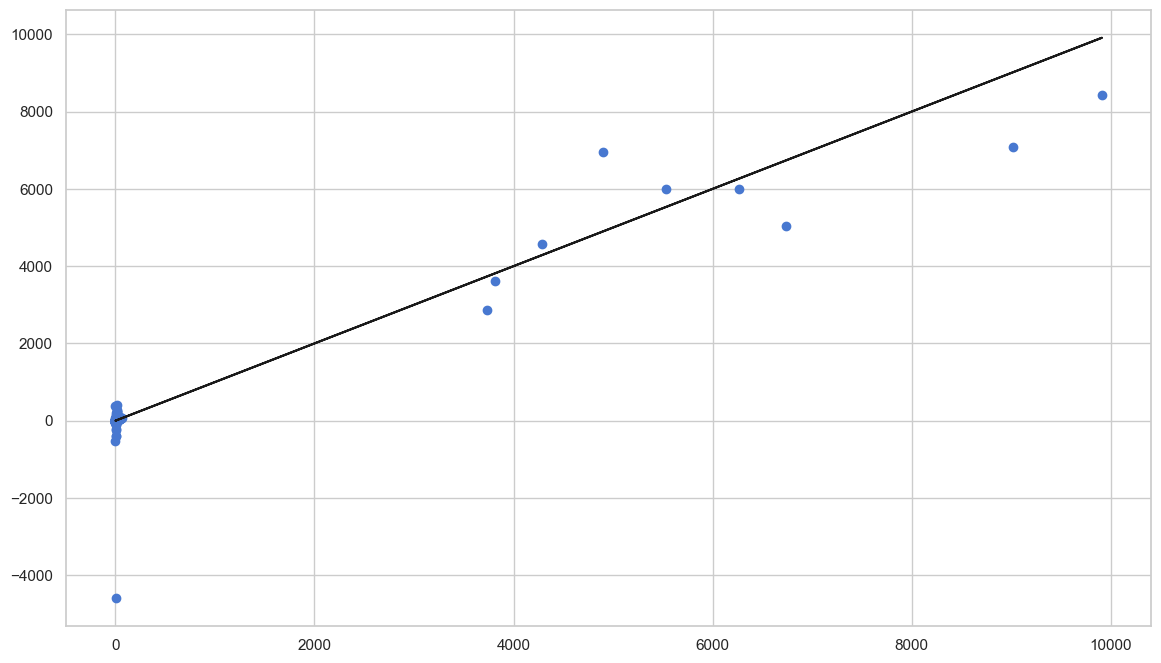

In [12]:
plt.scatter(y_test_list_ols, y_pred_list_ols)
plt.plot(y_test_list_ols, y_test_list_ols,'k-') # identity line

In [13]:
results_df_ols = pd.DataFrame(data=[["OLS Lineaer Regression", *evaluate(y_test_list_ols, y_pred_list_ols)]],
                            columns=['Model', 'MAE', 'RMSE', 'R-squared'])

pd.concat([results_df_ols], axis=0, ignore_index=True)

,Model,MAE,RMSE,R-squared
0,OLS Lineaer Regression,8.759739,102.408536,0.898848


In [ ]:
n_forecast = len(X) - n_train
result_ols = pd.DataFrame({'Return_Actual': y[-n_forecast:], 'Return_Predicted': y_pred_list_ols}, columns=['Return_Actual', 'Return_Predicted'])
result_ols.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.045046
Return_Predicted,0.045046,1.000000


### Since the result seems to be influened by the outliers significantly
### We try to do the comparsion after removing the outlier

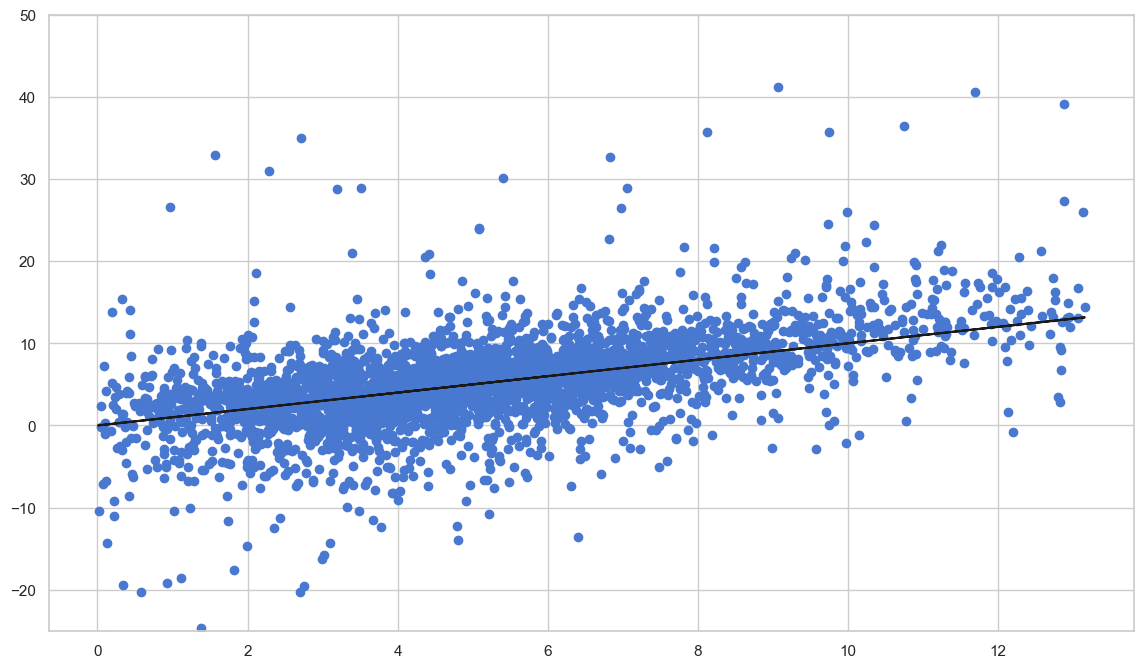

In [14]:
predf=pd.DataFrame({'test':y_test_list_ols,'predict':y_pred_list_ols})
non_outliner_df=predf[predf['predict'] <= predf['predict'].quantile(0.95)]
non_outliner_df=predf[predf['test'] <= predf['test'].quantile(0.95)]
# non_outliner_df=predf[predf['predict'] <= 600]
plt.scatter(non_outliner_df['test'], non_outliner_df['predict'])
plt.plot(non_outliner_df['test'],non_outliner_df['test'],'k-') # identity line
plt.ylim(-25,50)
plt.show()

In [15]:
n_forecast = len(X) - n_train
result_ols = pd.DataFrame({'Return_Actual': non_outliner_df['test'], 'Return_Predicted': non_outliner_df['predict']}, columns=['Return_Actual', 'Return_Predicted'])
result_ols.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.035386
Return_Predicted,0.035386,1.000000


#### Result for the OLS is poor due to the low correlation.
#### Since the PCA dimension reduction method only take 1 PCA into account and it is linear project, i.e. we have no idea what happen in the process (e.g. which features used or reduced)
#### Now we try to apply other feature reduction method to get a more logical approach

**bold text**# Alternative: SelectKbest

### Step 1: Use SelectKBest to select the optimal features

In [17]:
model_KBest = SelectKBest(score_func=f_regression, k=10)     #Select k most relevant features
                                                            #f_regression: F-value between label/feature for regression tasks.
model_KBest = model_KBest.fit(X, y)

KBest = model_KBest.get_support()       #Get a mask, or integer index, of the features selected.

data = {"Features":model_KBest.feature_names_in_,"Selection":KBest}
pd.DataFrame(data, columns = ['Features','Selection'])

,Features,Selection
0,roe,False
1,rote,False
2,roce,False
3,roic,False
4,roa,False
...,...,...
62,pocf,False
63,ev_sales,False
64,ev_ebitda,False
65,ev_ebit,False


In [18]:
data = {"Features":model_KBest.feature_names_in_,"P-value":model_KBest.pvalues_}
df = pd.DataFrame(data, columns = ['Features','P-value'])
df.sort_values(by='P-value', ascending=True).head(model_KBest.k)

,Features,P-value
66,ey,0.000000
57,ebitdaps,0.000000
56,ocfps,0.000000
55,fcfps,0.000000
54,saleps,0.000000
53,bvps,0.000000
52,eps,0.000000
41,F_eq_offer_fs,0.000002
24,cogsr,0.091798
34,rd,0.095488


In [19]:
#Identifying the selected features

KBest_feature = []

for i in range(0,KBest.shape[0]):
    if KBest[i] == True:
        K_feature = X.columns[i]
        KBest_feature.append(K_feature)

KBest_feature

['cogsr',
 'rd',
 'F_eq_offer_fs',
 'eps',
 'bvps',
 'saleps',
 'fcfps',
 'ocfps',
 'ebitdaps',
 'ey']

### Step 2: Train the model with the reduced number of features

In [25]:
# Pipeline

# Steps
steps_final = [('SelectKBest', SelectKBest(score_func=f_regression, k=10)),
               ('ols', LinearRegression())
              ]

pipeline_final = Pipeline(steps_final)

In [26]:
n_train = int(0.7 * len(X))

n_forecast = len(X) - n_train

n_records = len(X)

y_test_list_ols_kbest = []

y_pred_list_ols_kbest = []


j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list_ols_kbest.extend(y_pred)

    y_test_list_ols_kbest.extend(y_test)

    j += 1

### Step 3: Compare the model with the actual data

In [27]:
results_df_ols_kbest = pd.DataFrame(data=[["OLS Lineaer Regression (SelectKbest)", *evaluate(y_test_list_ols_kbest, y_pred_list_ols_kbest)]],
                            columns=['Model', 'MAE', 'RMSE', 'R-squared'])

pd.concat([results_df_ols,results_df_ols_kbest], axis=0, ignore_index=True)

,Model,MAE,RMSE,R-squared
0,OLS Lineaer Regression,8.759739,102.408536,0.898848
1,OLS Lineaer Regression (SelectKbest),9.405706,128.891011,0.839769


In [28]:
metrics.mean_squared_error(y_test_list_ols_kbest, y_pred_list_ols_kbest, squared=False)

128.89101113424496

In [29]:
n_forecast = len(X) - n_train
result_ols_kbest = pd.DataFrame({'Return_Actual': y[-n_forecast:], 'Return_Predicted': y_pred_list_ols_kbest}, columns=['Return_Actual', 'Return_Predicted'])
result_ols_kbest.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.918277
Return_Predicted,0.918277,1.000000


#### The result showed that the OLS prediction is terrible as showed in its low correlation
#### Thus, we can deduct that OLS is not a desireable model for such prediction

## Model 2: Random Forest Regression
<a id="randomforest"></a>

### Step 1: Grid Search to find the optimal hyperparameter

In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('RandomForestRegressor',RandomForestRegressor())
            ]
    pipeline = Pipeline(steps)
    return pipeline

def split(cfg):

    for i in np.arange(0.1, 1, 0.1):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, random_state = 1)

        model = pipeline(cfg).fit(X_train, y_train)

        y_pred = model.predict(X_test)

    score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    jprint(' > %.3f' % score_rmse)

    return score_rmse

def repeat_evaluate(config):
    key = str(config)
    scores = [split(config)]
    result = np.mean(scores)
    #print('> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(cfg_list):
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1], reverse=True)
    return scores

def model_configs():
    n = 50
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    #print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])
optimal_n_pca_comp

### Step 2: Train the model with the reduced number of features

In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('RandomForestRegressor',RandomForestRegressor())
            ]
    pipeline = Pipeline(steps)
    return pipeline

def model_configs():
    n = 25
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])

# Steps
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = optimal_n_pca_comp, random_state=1)),
               ('RandomForestRegressor', RandomForestRegressor())
              ]

pipeline_final = Pipeline(steps_final)

n_train = int(0.7 * len(X))
n_forecast = len(X) - n_train
n_records = len(X)

y_test_list_radforest = []
y_pred_list_radforest = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list_radforest.extend(y_pred)

    y_test_list_radforest.extend(y_test)

    j += 1

Total configs: 25


### Step 3: Compare the model with the actual data

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.045046
Return_Predicted,0.045046,1.000000


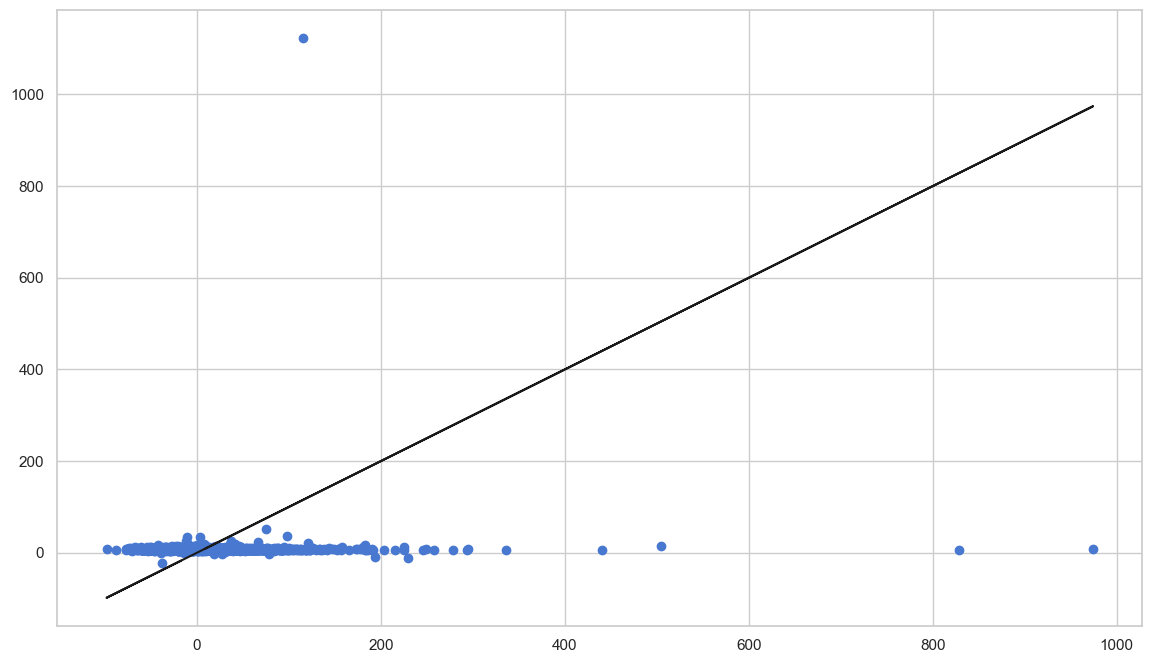

In [ ]:
plt.scatter(y_test_list_radforest, y_pred_list_radforest)
plt.plot(y_test_list_radforest, y_test_list_radforest,'k-') # identity line
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': y[-n_forecast:], 'Return_Predicted': y_pred_list_radforest}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

### Since the result seems to be influened by the outliers significantly
### We try to do the comparsion after removing the outlier

In [ ]:
results_df_ran = pd.DataFrame(data=[["Random Forest Regression", *evaluate(y_test_list_radforest, y_pred_list_radforest)]],
                            columns=['Model', 'MAE', 'RMSE', 'R-squared'])

pd.concat([results_df_ols,results_df_ran], axis=0, ignore_index=True)

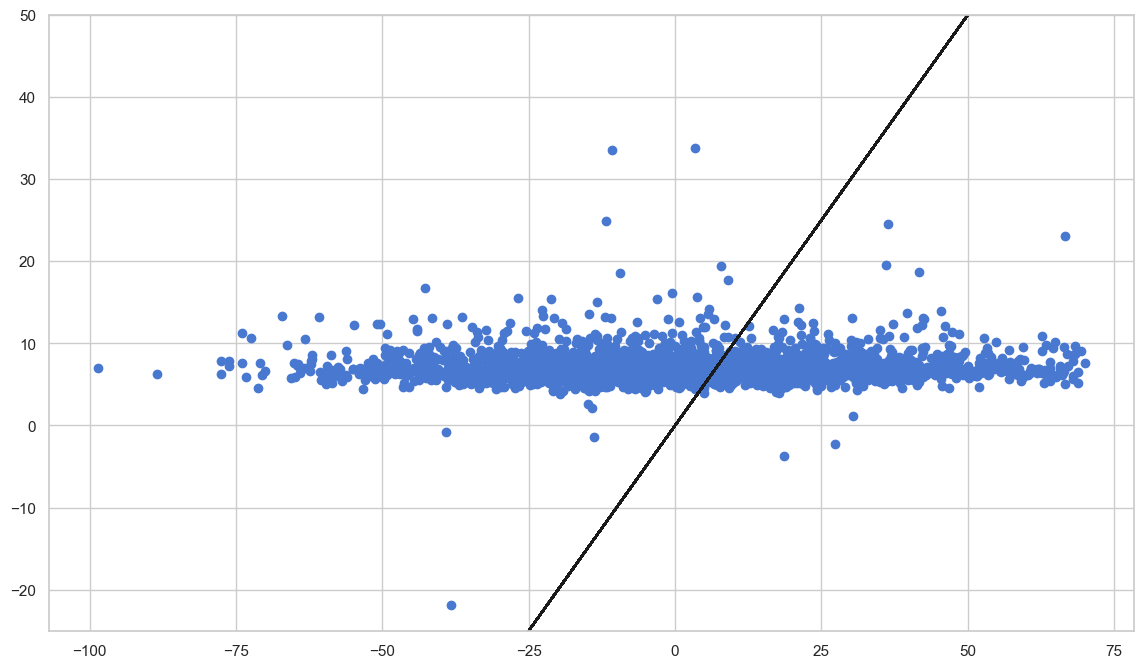

In [ ]:
predf=pd.DataFrame({'test':y_test_list,'predict':y_pred_list})
non_outliner_df=predf[predf['predict'] <= predf['predict'].quantile(0.95)]
non_outliner_df=predf[predf['test'] <= predf['test'].quantile(0.95)]
# non_outliner_df=predf[predf['predict'] <= 600]
plt.scatter(non_outliner_df['test'], non_outliner_df['predict'])
plt.plot(non_outliner_df['test'],non_outliner_df['test'],'k-') # identity line
plt.ylim(-25,50)
plt.show()

In [ ]:
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': non_outliner_df['test'], 'Return_Predicted': non_outliner_df['predict']}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.033939
Return_Predicted,0.033939,1.000000


#### Result for the OLS is poor due to the low correlation.
#### Since the PCA dimension reduction method only take 1 PCA into account and it is linear project, i.e. we have no idea what happen in the process (e.g. which features used or reduced)
#### Now we try to apply other feature reduction method to get a more logical approach

## Model 3: XGBoost Regression
<a id="xgb"></a>

### Step 1: Grid Search to find the optimal hyperparameter

In [ ]:
from xgboost import XGBRegressor
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('xgboost', xgb.XGBRegressor(objective='reg:squarederror', random_state=1))
             ]
    pipeline = Pipeline(steps)
    return pipeline

def split(cfg):

    for i in np.arange(0.1, 1, 0.1):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, random_state = 1)

        model = pipeline(cfg).fit(X_train, y_train)

        y_pred = model.predict(X_test)

    score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    #print(' > %.3f' % score_rmse)

    return score_rmse

def repeat_evaluate(config):
    key = str(config)
    scores = [split(config)]
    result = np.mean(scores)
    #print('> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(cfg_list):
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1], reverse=True)
    return scores

def model_configs():
    n = 50
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    #print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])
optimal_n_pca_comp

41

#### Note: The optimal number of PCA is 1 for Xgboost

### Step 2: Train the model with the reduced number of features

In [31]:
n_train = int(0.7 * len(X))
n_forecast = len(X) - n_train
n_records = len(X)
print(n_train,n_forecast,n_records)

8197 3513 11710


In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('xgboost', XGBRegressor(objective='reg:squarederror', random_state=1))
            ]
    pipeline = Pipeline(steps)
    return pipeline

def model_configs():
    n = 25
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    print('Total configs: %d' % len(configs))
    return configs

#cfg_list = model_configs()
#scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
#optimal_n_pca_comp = int(scores[len(scores)-1][0])
optimal_n_pca_comp = 41

# Steps
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = optimal_n_pca_comp, random_state=1)),
               ('xgboost', xgb.XGBRegressor(objective='reg:squarederror', random_state=1))
              ]

pipeline_final = Pipeline(steps_final)

n_train = int(0.7 * len(X))
n_forecast = len(X) - n_train
n_records = len(X)

y_test_list_xgb = []
y_pred_list_xgb = []

j = 0

for i in range(n_train,1,-1):
    print(i)

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list_xgb.extend(y_pred)

    y_test_list_xgb.extend(y_test)

    j += 1

### Step 3: Compare the model with the actual data

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.563062
Return_Predicted,0.563062,1.000000


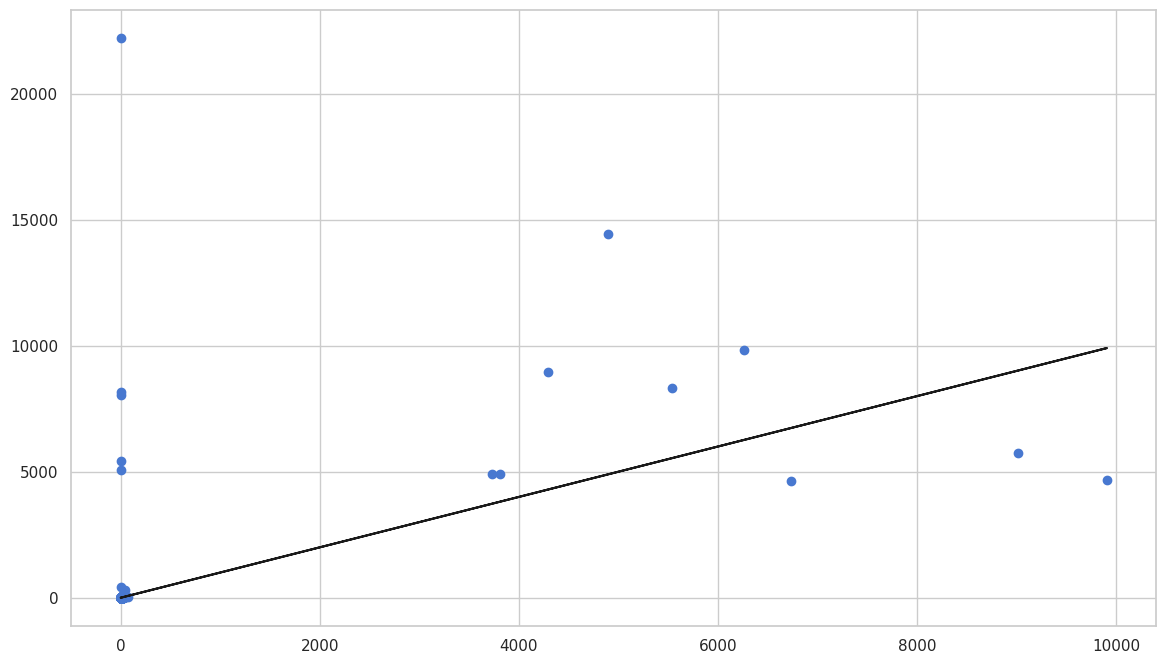

In [ ]:
plt.scatter(y_test_list_xgb, y_pred_list_xgb)
plt.plot(y_test_list_xgb, y_test_list_xgb,'k-') # identity line
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': y[-n_forecast:], 'Return_Predicted': y_pred_list_xgb}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

### Since the result seems to be influened by the outliers significantly
### We try to do the comparsion after removing the outlier

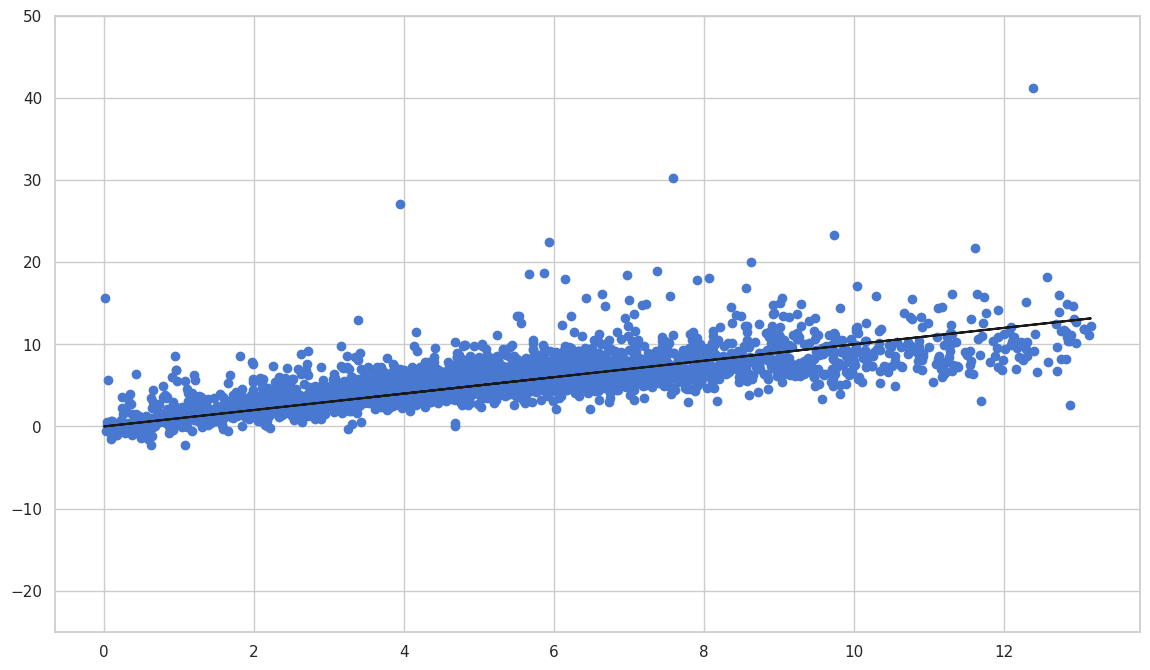

In [ ]:
predf=pd.DataFrame({'test':y_test_list,'predict':y_pred_list})
non_outliner_df=predf[predf['predict'] <= predf['predict'].quantile(0.95)]
non_outliner_df=predf[predf['test'] <= predf['test'].quantile(0.95)]
# non_outliner_df=predf[predf['predict'] <= 600]
plt.scatter(non_outliner_df['test'], non_outliner_df['predict'])
plt.plot(non_outliner_df['test'],non_outliner_df['test'],'k-') # identity line
plt.ylim(-25,50)
plt.show()

In [ ]:
results_df_xgb = pd.DataFrame(data=[["XGBoost Regression", *evaluate(y_test_list_xgb, y_pred_list_xgb)]],
                            columns=['Model', 'MAE', 'RMSE', 'R-squared'])

pd.concat([results_df_ols,results_df_ran,results_df_xgb], axis=0, ignore_index=True)

In [ ]:
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': non_outliner_df['test'], 'Return_Predicted': non_outliner_df['predict']}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.014137
Return_Predicted,0.014137,1.000000


#### Result for the XGboost is poor due to the low correlation.
#### Since the PCA dimension reduction method only take 1 PCA into account and it is linear project, i.e. we have no idea what happen in the process (e.g. which features used or reduced)


## Model 4: SVM Regression
<a id="SVMreg"></a>

### Step 1: Grid Search to find the optimal hyperparameter

In [ ]:
from sklearn.svm import SVR

def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('SVM Regression',SVR(kernel='rbf'))
            ]
    pipeline = Pipeline(steps)
    return pipeline

def split(cfg):

    for i in np.arange(0.1, 1, 0.1):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, random_state = 1)

        model = pipeline(cfg).fit(X_train, y_train)

        y_pred = model.predict(X_test)

    score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    #print(' > %.3f' % score_rmse)

    return score_rmse

def repeat_evaluate(config):
    key = str(config)
    scores = [split(config)]
    result = np.mean(scores)
    #print('> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(cfg_list):
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1], reverse=True)
    return scores

def model_configs():
    n = 50
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    #print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])
optimal_n_pca_comp

### Step 2: Train the model with the reduced number of features

In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('SVM Regression',SVR(kernel='rbf'))
            ]
    pipeline = Pipeline(steps)
    return pipeline

def model_configs():
    n = 25
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    print('Total configs: %d' % len(configs))
    return configs

#cfg_list = model_configs()
#scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
#optimal_n_pca_comp = int(scores[len(scores)-1][0])

# Steps
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = optimal_n_pca_comp, random_state=1)),
               ('SVM Regression',SVR(kernel='rbf'))
              ]

pipeline_final = Pipeline(steps_final)

n_train = int(0.7 * len(X))
n_forecast = len(X) - n_train
n_records = len(X)

y_test_list_svm = []
y_pred_list_svm = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list_svm.extend(y_pred)

    y_test_list_svm.extend(y_test)

    j += 1

Total configs: 25


### Step 3: Compare the model with the actual data

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.045046
Return_Predicted,0.045046,1.000000


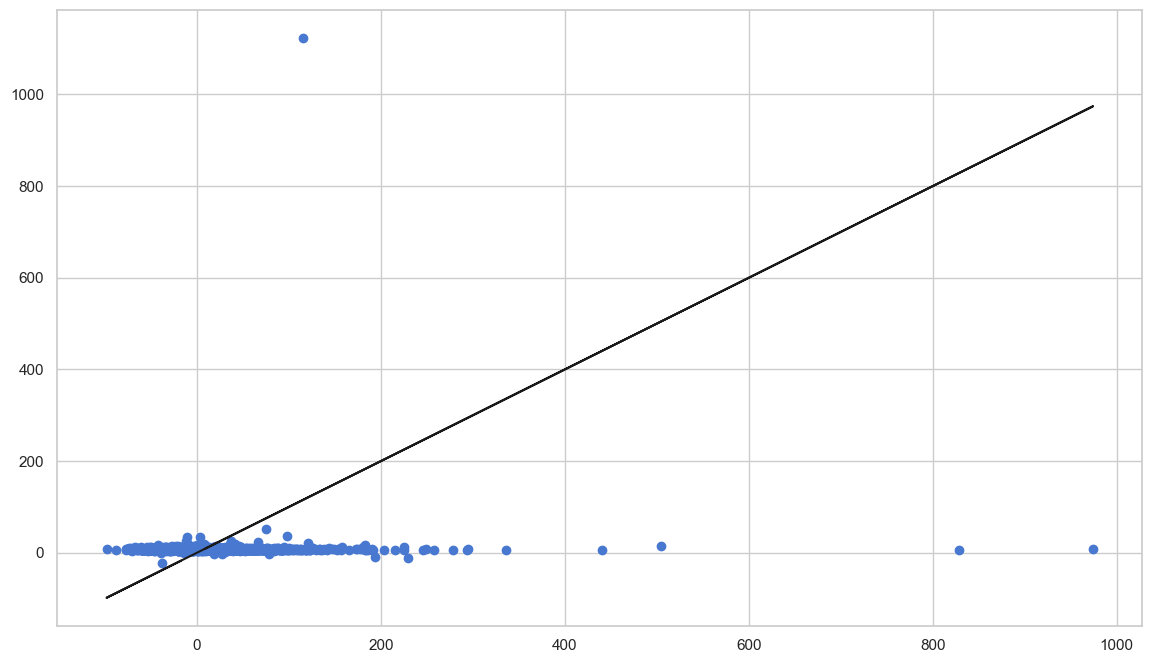

In [ ]:
plt.scatter(y_test_list_svm, y_pred_list_svm)
plt.plot(y_test_list_svm, y_test_list_svm,'k-') # identity line
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': y[-n_forecast:], 'Return_Predicted': y_pred_list_svm}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

In [ ]:
results_df_svm = pd.DataFrame(data=[["Random Forest Regression", *evaluate(y_test_list_svm, y_pred_list_svm)]],
                            columns=['Model', 'MAE', 'RMSE', 'R-squared'])

pd.concat([results_df_ols,results_df_ran,results_df_xgb,results_df_svm], axis=0, ignore_index=True)

### Since the result seems to be influened by the outliers significantly
### We try to do the comparsion after removing the outlier

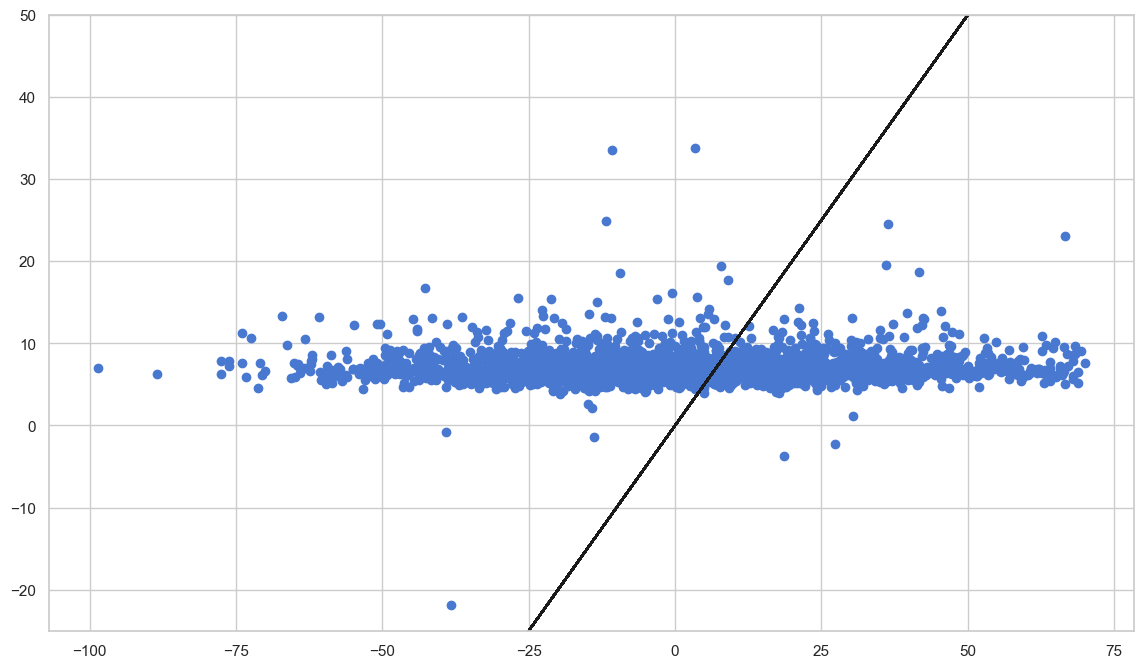

In [ ]:
predf=pd.DataFrame({'test':y_test_list,'predict':y_pred_list})
non_outliner_df=predf[predf['predict'] <= predf['predict'].quantile(0.95)]
non_outliner_df=predf[predf['test'] <= predf['test'].quantile(0.95)]
# non_outliner_df=predf[predf['predict'] <= 600]
plt.scatter(non_outliner_df['test'], non_outliner_df['predict'])
plt.plot(non_outliner_df['test'],non_outliner_df['test'],'k-') # identity line
plt.ylim(-25,50)
plt.show()

In [ ]:
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': non_outliner_df['test'], 'Return_Predicted': non_outliner_df['predict']}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.033939
Return_Predicted,0.033939,1.000000


#### Result for the OLS is poor due to the low correlation.
#### Since the PCA dimension reduction method only take 1 PCA into account and it is linear project, i.e. we have no idea what happen in the process (e.g. which features used or reduced)
#### Now we try to apply other feature reduction method to get a more logical approach

## Model 5: RNN Neural Networking Model
<a id="RNN"></a>

In [ ]:
from sklearn.metrics import mean_squared_error as mse

n_steps = 20
n_features = 66

n_train = int(0.7 * len(X))
n_forecast = len(X) - n_train
n_records = len(X)

n = n_forecast

# split a multivariate sequence into samples
def split_sequences(X, n_steps):
    X_seq = list()
    for i in range(len(X)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(X):
            break
        # gather input and output parts of the pattern
        seq_x = X.iloc[i:end_ix, :]
        X_seq.append(seq_x)
    return np.array(X_seq)


X_train = split_sequences(X.iloc[:-n], n_steps)
for i in range(X_train.shape[1]):
  for j in range(X_train.shape[2]):
    X_train[:,i,j] = (X_train[:,i,j]-X_train[:,i,j].mean())/(X_train[:,i,j].std()+1e-12)
y_train = y.iloc[n_steps:-n+1].values
print(X_train.shape, y_train.shape)

X_test = split_sequences(X.iloc[-n-n_steps+1:], n_steps)
for i in range(X_test.shape[1]):
  for j in range(X_test.shape[2]):
    X_test[:,i,j] = (X_test[:,i,j]-X_test[:,i,j].mean())/(X_test[:,i,j].std()+1e-12)
y_test = y.iloc[-n:].values
print(X_test.shape, y_test.shape)


(8178, 20, 66) (8178,)
(3513, 20, 66) (3513,)


In [ ]:
#RNN model
model = Sequential()
model.add(SimpleRNN(128, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [ ]:
#Set Seed
np.random.seed(1)
tf.random.set_seed(2)

model_rnn = model.fit(X_train, y_train, batch_size=60, epochs=60, shuffle=False, verbose=False)
RNN_pred = model.predict(X_test)
RNN_pred



110/110 [==============================] - 1s 3ms/step


array([[ -1.3783128 ],
       [  0.73436826],
       [  9.985776  ],
       ...,
       [  0.44443434],
       [ 22.494768  ],
       [-30.334585  ]], dtype=float32)

In [ ]:
rmse_rnn = np.sqrt(mse(y_test, RNN_pred))
print('The RMSE value of RNN model {:.4f}'.format(rmse_rnn))

The RMSE value of RNN model 48.3231


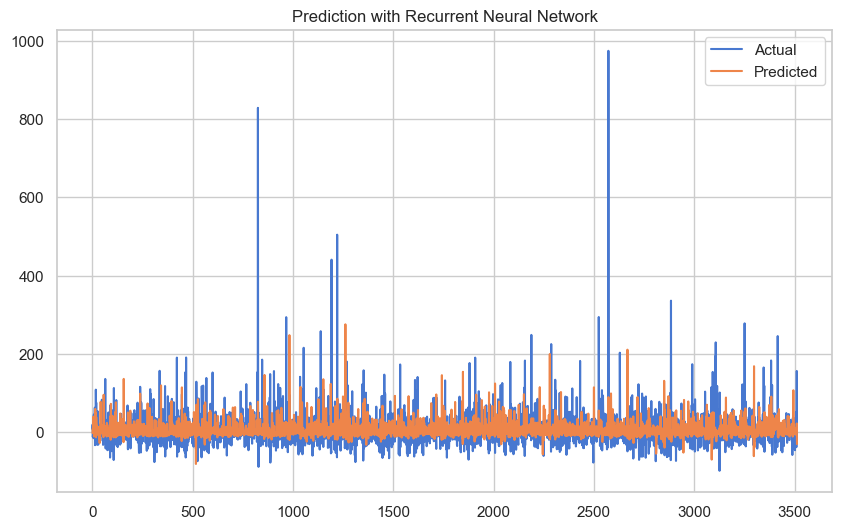

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(RNN_pred, label='Predicted')
plt.title('Prediction with Recurrent Neural Network', fontsize=12)
plt.legend()
plt.show()

In [ ]:
results_df_rnn = pd.DataFrame(data=[["Random Forest Regression", *evaluate(y_test, RNN_pred)]],
                            columns=['Model', 'MAE', 'RMSE', 'R-squared'])

pd.concat([results_df_ols,results_df_ran,results_df_xgb,results_df_svm,results_df_rnn], axis=0, ignore_index=True)

## Model 6: LSTM Neural Networking Model
<a id="LSTM"></a>

In [ ]:
#LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])


In [ ]:
#Set Seed
np.random.seed(1)
tf.random.set_seed(2)

model_lstm = model.fit(X_train, y_train, batch_size=60, epochs=60, shuffle=False, verbose=False)
LSTM_pred = model.predict(X_test)
LSTM_pred

110/110 [==============================] - 1s 8ms/step


array([[ 2.0437646],
       [ 4.6970973],
       [ 3.9098842],
       ...,
       [ 7.7866735],
       [16.541145 ],
       [ 7.3832784]], dtype=float32)

In [ ]:
rmse_lstm = np.sqrt(mse(y_test, LSTM_pred))
print('The RMSE value of LSTM model {:.4f}'.format(rmse_lstm))

The RMSE value of LSTM model 44.9098


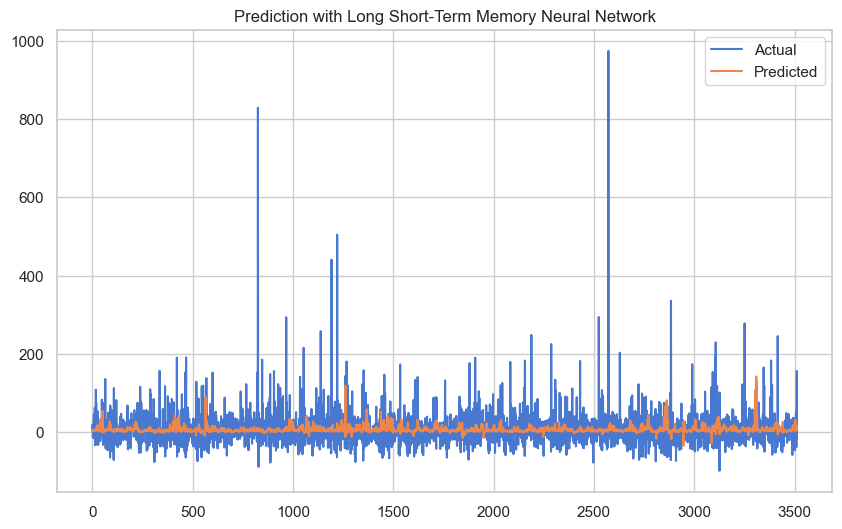

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(LSTM_pred, label='Predicted')
plt.title('Prediction with Long Short-Term Memory Neural Network', fontsize=12)
plt.legend()
plt.show()

In [ ]:
results_df_lstm = pd.DataFrame(data=[["Random Forest Regression", *evaluate(y_test, LSTM_pred)]],
                            columns=['Model', 'MAE', 'RMSE', 'R-squared'])

pd.concat([results_df_ols,results_df_ran,results_df_xgb,results_df_svm,results_df_rnn,results_df_lstm], axis=0, ignore_index=True)

### Comment
#### By graph, we can clearly see that the RNN model is over-estimating the result whereas LSTM model underestimating it
#### Since their RMSE are both larger than 40, meaning their prediction are at least 40 units away from the actual value, meaning that the model is not reliable

# Comment on Improvement
### The result above showed that all the model are not effective in prediction, and the regression plot showed the regression line is suffering the problem of outliers.
### Therefore, we assume the data exist significant outlier that impact the result.
### Solution: We will use outlier detection model to spot and remove those outliners, then we re-train the data
<a id="comment2improve"></a>

# 1) Outlier Detection
<a id="outlier"></a>

## Outlier Detection Model 1: Local Outlier Factor (LOF)

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Part 1: Use randomized search to find the optimal number of neighbors
param_dist = {'n_neighbors': [5, 10, 20, 30, 40]}
lof = LocalOutlierFactor(contamination='auto')
random_search = RandomizedSearchCV(lof, param_distributions=param_dist, n_iter=5)
random_search.fit(X)
best_n_neighbors = random_search.best_params_['n_neighbors']
print('Best n_neighbors:', best_n_neighbors)

# Part 2: Print out the Z value of the outliers
lof = LocalOutlierFactor(n_neighbors=best_n_neighbors, contamination='auto')
y_pred = lof.fit_predict(X)
outliers = X[y_pred == -1]
outlier_ids = Z[y_pred == -1]
print('Outlier IDs:', outlier_ids)

# Part 3: Define new X such that it removes all the outliers that it detected
X_new = X[y_pred == 1]
y_new = y[y_pred == 1]

## Outlier Detection Model 2: Isolation Forest

In [ ]:
isof = isof.fit(X)

# Part 1: Use randomized search to find the optimal number of nu
param_dist = {'n_estimators': [60, 80, 100, 120, 140]}
isof = IsolationForest(n_estimators=100, max_samples=len(X), contamination="auto", random_state=1)
random_search = RandomizedSearchCV(isof, param_distributions=param_dist, n_iter=5)
random_search.fit(X)
best_n_estimators = random_search.best_params_['n_estimators']
print('best n_estimators:', best_n_estimators)

# Part 2: Print out the Z value of the outliers
isof = IsolationForest(n_estimators=best_n_estimators, max_samples=len(X), contamination="auto", random_state=1)
isof = isof.fit(X)
y_pred = isof.predict(X)
outliers = X[y_pred == -1]
outlier_ids = Z[y_pred == -1]
print('Outlier IDs:', outlier_ids)

# Part 3: Define new X such that it removes all the outliers that it detected
X_new = X[y_pred == 1]
y_new = y[y_pred == 1]

## Outlier Detection Model 3: One-class SVM

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Part 1: Use randomized search to find the optimal number of nu
param_dist = {'nu': [0.01, 0.05, 0.1, 0.15, 0.2]}
svm = OneClassSVM(kernel='linear')
random_search = RandomizedSearchCV(svm, param_distributions=param_dist, n_iter=5)
random_search = random_search.fit(X)
best_nu = random_search.best_params_['nu']
print('Best nu:', best_nu)

# Part 2: Print out the Z value of the outliers
svm = OneClassSVM(nu=best_nu, kernel='linear')
svm = svm.fit(X)
y_pred = svm.predict(X)
outliers = X[y_pred == -1]
outlier_ids = Z[y_pred == -1]
print('Outlier IDs:', outlier_ids)

# Part 3: Define new X such that it removes all the outliers that it detected
X_new = X[y_pred == 1]
y_new = y[y_pred == 1]

## Result of outliers detection

# 2) Alternative Model
<a id="AlternativeModel"></a>

## Alternative Model 1: Ridge Regression
<a id="ridge"></a>

### Step 1: Grid Search to find the optimal hyperparameter

In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('Ridge',Ridge())
            ]
    pipeline = Pipeline(steps)
    return pipeline

def split(cfg):

    for i in np.arange(0.1, 1, 0.1):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, random_state = 1)

        model = pipeline(cfg).fit(X_train, y_train)

        y_pred = model.predict(X_test)

    score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    #print(' > %.3f' % score_rmse)

    return score_rmse

def repeat_evaluate(config):
    key = str(config)
    scores = [split(config)]
    result = np.mean(scores)
    #print('> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(cfg_list):
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1], reverse=True)
    return scores

def model_configs():
    n = 50
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    #print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])
optimal_n_pca_comp

1

#### Note: The optimal number of PCA is 1 for OLS

### Step 2: Train the model with the reduced number of features

In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('Ridge',Ridge())
            ]
    pipeline = Pipeline(steps)
    return pipeline

def model_configs():
    n = 25
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])

# Steps
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = optimal_n_pca_comp, random_state=1)),
               ('Ridge', Ridge())
              ]

pipeline_final = Pipeline(steps_final)

n_train = int(0.7 * len(X))
n_forecast = len(X) - n_train
n_records = len(X)

y_test_list = []
y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

Total configs: 25


### Step 3: Compare the model with the actual data

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.045046
Return_Predicted,0.045046,1.000000


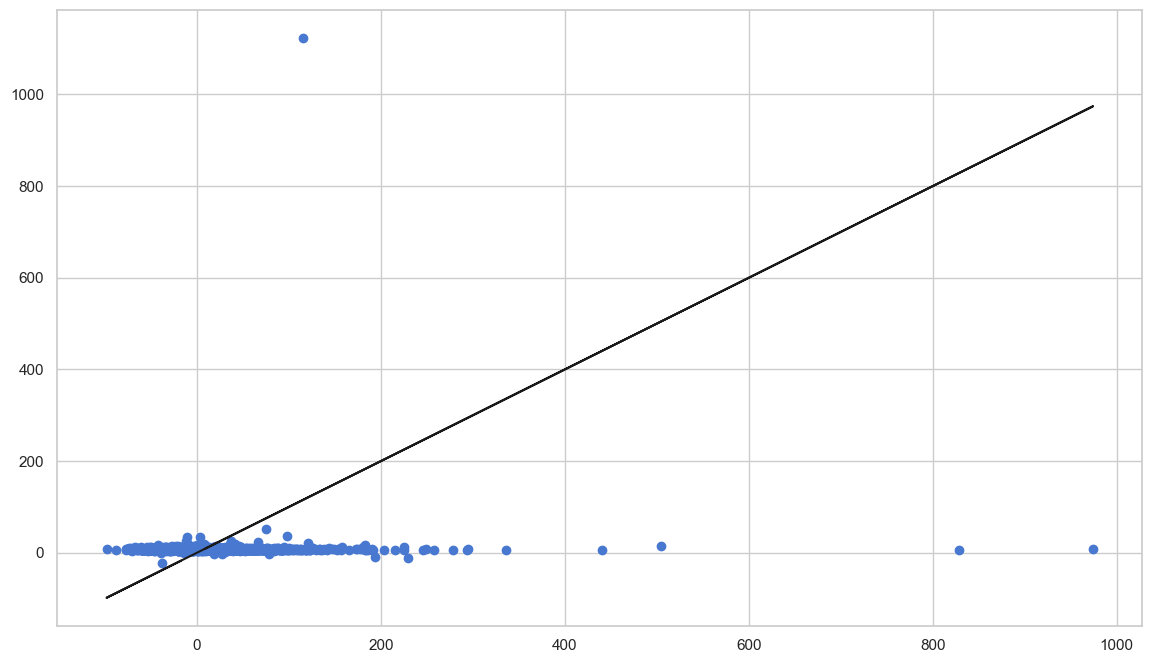

In [ ]:
plt.scatter(y_test_list, y_pred_list)
plt.plot(y_test_list, y_test_list,'k-') # identity line
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': y[-n_forecast:], 'Return_Predicted': y_pred_list}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

### Since the result seems to be influened by the outliers significantly
### We try to do the comparsion after removing the outlier

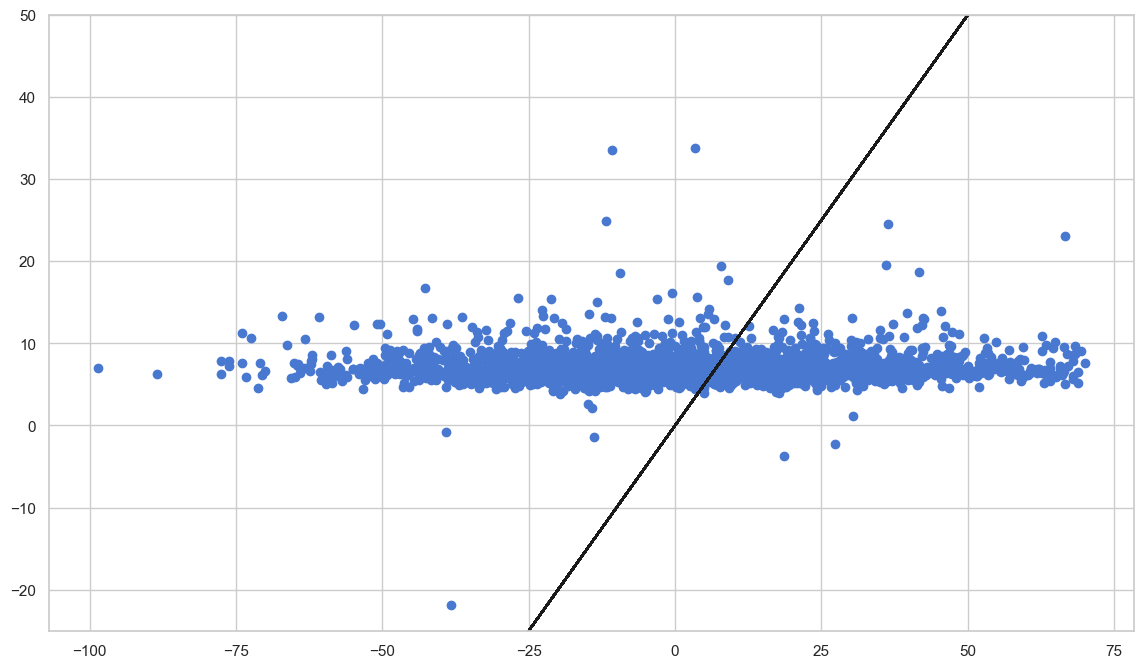

In [ ]:
predf=pd.DataFrame({'test':y_test_list,'predict':y_pred_list})
non_outliner_df=predf[predf['predict'] <= predf['predict'].quantile(0.95)]
non_outliner_df=predf[predf['test'] <= predf['test'].quantile(0.95)]
# non_outliner_df=predf[predf['predict'] <= 600]
plt.scatter(non_outliner_df['test'], non_outliner_df['predict'])
plt.plot(non_outliner_df['test'],non_outliner_df['test'],'k-') # identity line
plt.ylim(-25,50)
plt.show()

In [ ]:
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': non_outliner_df['test'], 'Return_Predicted': non_outliner_df['predict']}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.033939
Return_Predicted,0.033939,1.000000


#### Result for the OLS is poor due to the low correlation.
#### Since the PCA dimension reduction method only take 1 PCA into account and it is linear project, i.e. we have no idea what happen in the process (e.g. which features used or reduced)
#### Now we try to apply other feature reduction method to get a more logical approach

### Alternative: SelectKbest

In [ ]:
model_KBest = SelectKBest(score_func=f_regression, k=20)     #Select k most relevant features
                                                            #f_regression: F-value between label/feature for regression tasks.
model_KBest = model_KBest.fit(X, y)

KBest = model_KBest.get_support()       #Get a mask, or integer index, of the features selected.

data = {"Features":model_KBest.feature_names_in_,"Selection":KBest}
pd.DataFrame(data, columns = ['Features','Selection'])

,Features,Selection
0,rote,False
1,roce,False
2,roic,False
3,roa,True
4,rota,True
...,...,...
61,pocf,False
62,ev_sales,False
63,ev_ebitda,False
64,ev_ebit,True


In [ ]:
data = {"Features":model_KBest.feature_names_in_,"P-value":model_KBest.pvalues_}
df = pd.DataFrame(data, columns = ['Features','P-value'])
df.sort_values(by='P-value', ascending=True).head(model_KBest.k)

,Features,P-value
6,roa_gp,5.489549e-24
18,turn,7.344450e-23
38,F_lever_chg,3.193096e-19
45,sloan,3.711740e-08
46,price_eop,1.241251e-07
33,rd,8.475292e-07
5,roa_cfo,3.586505e-06
10,roa_fcf,2.377100e-05
43,F_score,3.060555e-05
17,lever,3.063435e-05


In [ ]:
#Identifying the selected features

KBest_feature = []

for i in range(0,KBest.shape[0]):
    if KBest[i] == True:
        K_feature = X.columns[i]
        KBest_feature.append(K_feature)

print("Below is the features that we will be selected to train the model")
KBest_feature

Below is the features that we will be selected to train the model


['roa',
 'rota',
 'roa_cfo',
 'roa_gp',
 'roa_fcf',
 'lever',
 'turn',
 'rd_sale',
 'rd_oi',
 'rd_ocf',
 'rd',
 'F_lever_chg',
 'F_eq_offer_fs',
 'F_score',
 'sloan',
 'price_eop',
 'bv_eop',
 'saleps',
 'ev_ebit',
 'ey']

In [ ]:
# Pipeline

# Steps
steps_final = [('SelectKBest', SelectKBest(score_func=f_regression, k=52)),
               ('rig', Ridge())
              ]

pipeline_final = Pipeline(steps_final)

In [ ]:
n_train = 334

n_records = len(X)

y_test_list = []

y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1


In [ ]:
metrics.mean_squared_error(y_test_list, y_pred_list, squared=False)


8788.462056864635

In [ ]:
n_forecast = len(X) - n_train
result_rig_kbest = pd.DataFrame({'Return_Actual': y[-n_forecast:], 'Return_Predicted': y_pred_list}, columns=['Return_Actual', 'Return_Predicted'])
result_rig_kbest.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,-0.000417
Return_Predicted,-0.000417,1.000000


## Alternative Model 2: Lasso Regression
<a id="lasso"></a>

### Step 1: Grid Search to find the optimal hyperparameter

In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('Lasso',Lasso())
            ]
    pipeline = Pipeline(steps)
    return pipeline

def split(cfg):

    for i in np.arange(0.1, 1, 0.1):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, random_state = 1)

        model = pipeline(cfg).fit(X_train, y_train)

        y_pred = model.predict(X_test)

    score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    #print(' > %.3f' % score_rmse)

    return score_rmse

def repeat_evaluate(config):
    key = str(config)
    scores = [split(config)]
    result = np.mean(scores)
    #print('> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(cfg_list):
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1], reverse=True)
    return scores

def model_configs():
    n = 50
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    #print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])
optimal_n_pca_comp

1

#### Note: The optimal number of PCA is 1 for OLS

### Step 2: Train the model with the reduced number of features

In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('Lasso',Lasso())
            ]
    pipeline = Pipeline(steps)
    return pipeline

def model_configs():
    n = 25
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])

# Steps
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = optimal_n_pca_comp, random_state=1)),
               ('Lasso', Lasso())
              ]

pipeline_final = Pipeline(steps_final)

n_train = int(0.7 * len(X))
n_forecast = len(X) - n_train
n_records = len(X)

y_test_list = []
y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

Total configs: 25


### Step 3: Compare the model with the actual data

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.045281
Return_Predicted,0.045281,1.000000


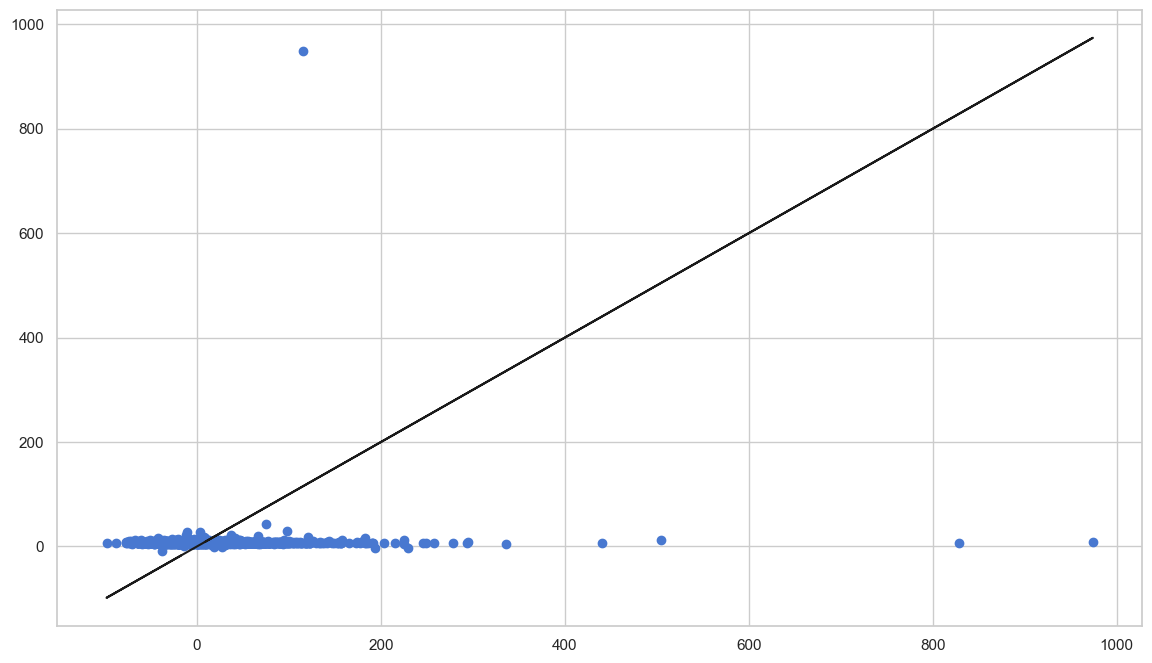

In [ ]:
plt.scatter(y_test_list, y_pred_list)
plt.plot(y_test_list, y_test_list,'k-') # identity line
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': y[-n_forecast:], 'Return_Predicted': y_pred_list}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

### Since the result seems to be influened by the outliers significantly
### We try to do the comparsion after removing the outlier

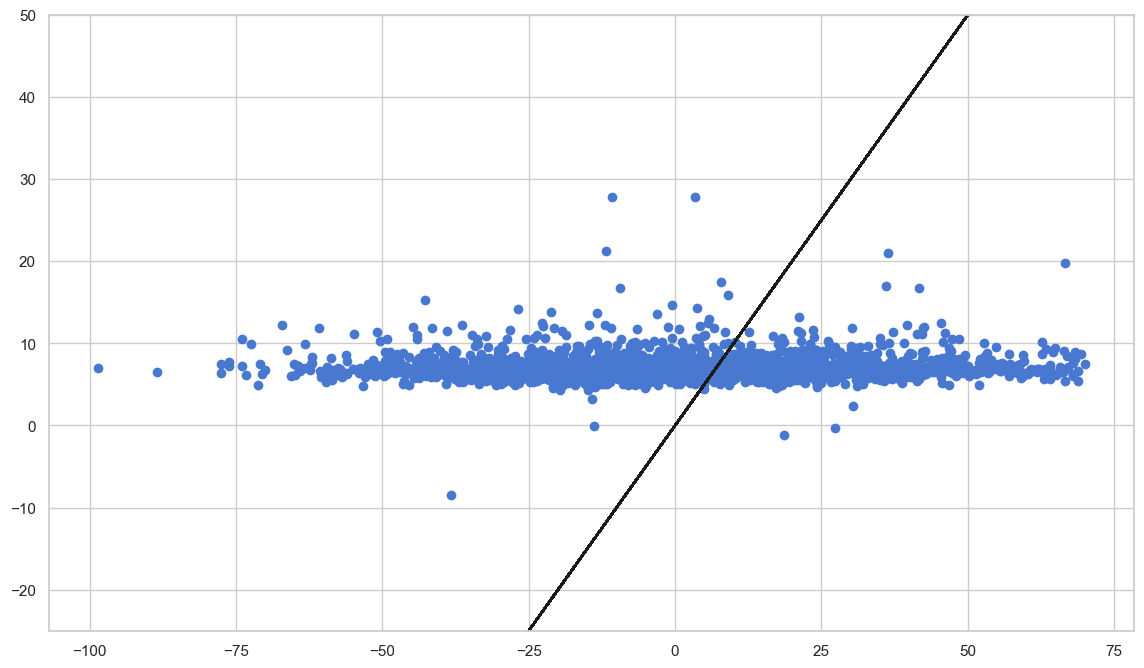

In [ ]:
predf=pd.DataFrame({'test':y_test_list,'predict':y_pred_list})
non_outliner_df=predf[predf['predict'] <= predf['predict'].quantile(0.95)]
non_outliner_df=predf[predf['test'] <= predf['test'].quantile(0.95)]
# non_outliner_df=predf[predf['predict'] <= 600]
plt.scatter(non_outliner_df['test'], non_outliner_df['predict'])
plt.plot(non_outliner_df['test'],non_outliner_df['test'],'k-') # identity line
plt.ylim(-25,50)
plt.show()

In [ ]:
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': non_outliner_df['test'], 'Return_Predicted': non_outliner_df['predict']}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.030881
Return_Predicted,0.030881,1.000000


## Alternative Model 3: Elastic Net Regression
<a id="elasticnet"></a>

### Step 1: Grid Search to find the optimal hyperparameter

In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('ElasticNet',ElasticNet())
            ]
    pipeline = Pipeline(steps)
    return pipeline

def split(cfg):

    for i in np.arange(0.1, 1, 0.1):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = i, random_state = 1)

        model = pipeline(cfg).fit(X_train, y_train)

        y_pred = model.predict(X_test)

    score_rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    #print(' > %.3f' % score_rmse)

    return score_rmse

def repeat_evaluate(config):
    key = str(config)
    scores = [split(config)]
    result = np.mean(scores)
    #print('> Model[%s] %.3f' % (key, result))
    return (key, result)

def grid_search(cfg_list):
    scores = [repeat_evaluate(cfg) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1], reverse=True)
    return scores

def model_configs():
    n = 50
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    #print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])
optimal_n_pca_comp

1

#### Note: The optimal number of PCA is 1 for OLS

### Step 2: Train the model with the reduced number of features

In [ ]:
def pipeline(config):
    n_comps = config
    steps = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
             ('pca', PCA(n_components = n_comps, random_state=1)),
             ('ElasticNet',ElasticNet())
            ]
    pipeline = Pipeline(steps)
    return pipeline

def model_configs():
    n = 25
    n_comps = [i for i in range(1, n+1)]
    configs = list()

    for k in n_comps:
        cfg = k
        configs.append(cfg)

    print('Total configs: %d' % len(configs))
    return configs

cfg_list = model_configs()
scores = grid_search(cfg_list)

#The optimal number of features for OLS from PCA grid search
optimal_n_pca_comp = int(scores[len(scores)-1][0])

# Steps
steps_final = [('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
               ('pca', PCA(n_components = optimal_n_pca_comp, random_state=1)),
               ('ElasticNet', ElasticNet())
              ]

pipeline_final = Pipeline(steps_final)

n_train = int(0.7 * len(X))
n_forecast = len(X) - n_train
n_records = len(X)

y_test_list = []
y_pred_list = []

j = 0

for i in range(n_train, n_records):

    X_train, X_test, y_train, y_test = X[j:i], X[i:i+1], y[j:i], y[i:i+1]

    model = pipeline_final.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    y_pred_list.extend(y_pred)

    y_test_list.extend(y_test)

    j += 1

Total configs: 25


### Step 3: Compare the model with the actual data

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.045166
Return_Predicted,0.045166,1.000000


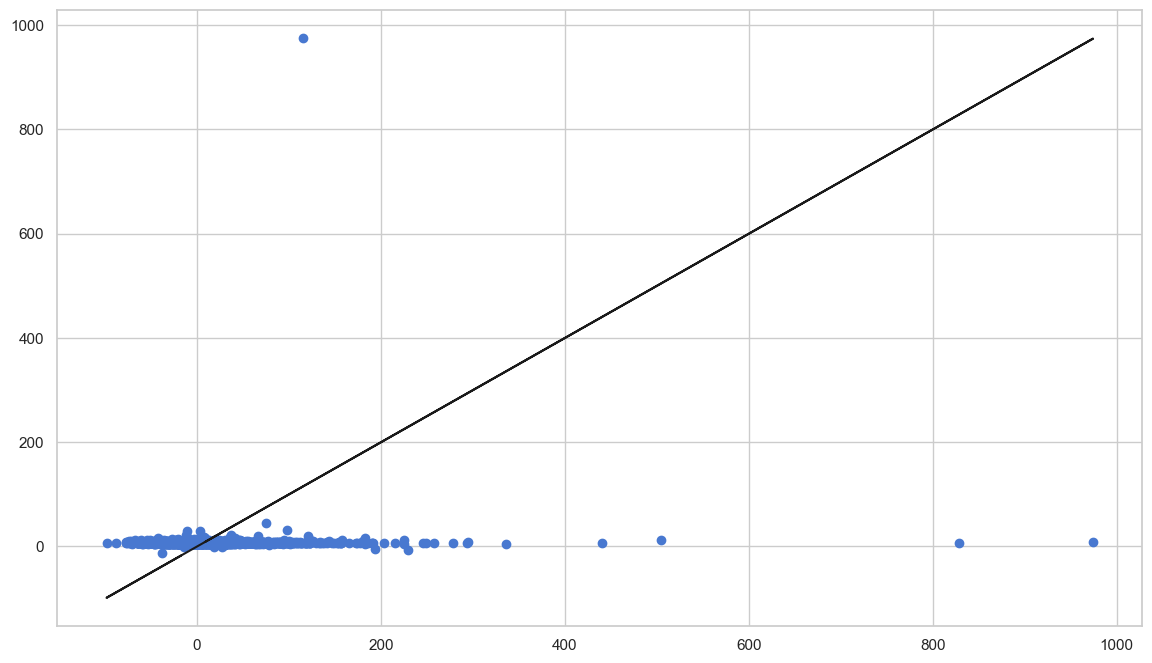

In [ ]:
plt.scatter(y_test_list, y_pred_list)
plt.plot(y_test_list, y_test_list,'k-') # identity line
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': y[-n_forecast:], 'Return_Predicted': y_pred_list}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

### Since the result seems to be influened by the outliers significantly
### We try to do the comparsion after removing the outlier

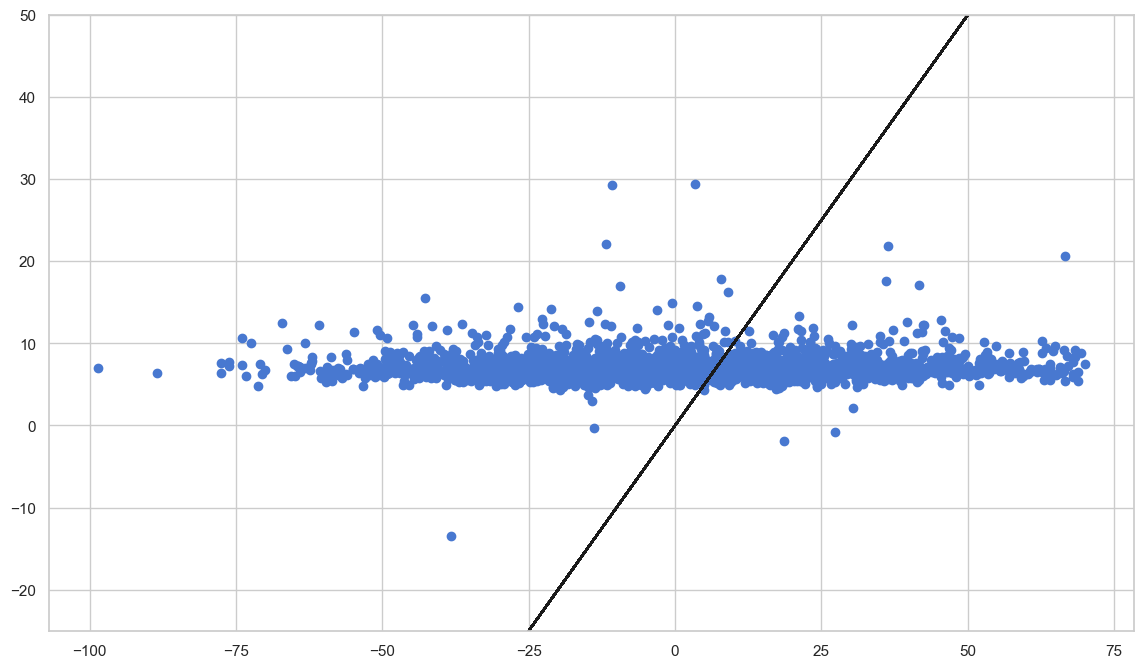

In [ ]:
predf=pd.DataFrame({'test':y_test_list,'predict':y_pred_list})
non_outliner_df=predf[predf['predict'] <= predf['predict'].quantile(0.95)]
non_outliner_df=predf[predf['test'] <= predf['test'].quantile(0.95)]
# non_outliner_df=predf[predf['predict'] <= 600]
plt.scatter(non_outliner_df['test'], non_outliner_df['predict'])
plt.plot(non_outliner_df['test'],non_outliner_df['test'],'k-') # identity line
plt.ylim(-25,50)
plt.show()

In [ ]:
n_forecast = len(X) - n_train
result_rig = pd.DataFrame({'Return_Actual': non_outliner_df['test'], 'Return_Predicted': non_outliner_df['predict']}, columns=['Return_Actual', 'Return_Predicted'])
result_rig.corr()

,Return_Actual,Return_Predicted
Return_Actual,1.000000,0.031683
Return_Predicted,0.031683,1.000000
